# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


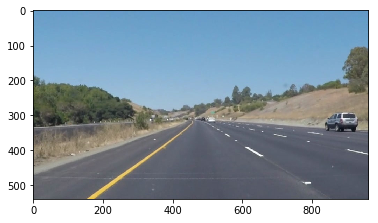

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(img, lines)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def length_of_line (line):
    """
    'length_of_line' function calculates the length of detecetd line
    
    inputs:
        line
    outputs:
        length of line
    """
    for x1,y1,x2,y2 in line:
        len_line = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
    return len_line


def gradient_cal(line):

    """
    'geadient_cal' function has to calculate the gradient of a straight line based on start and end point of the line
    
    inputs:
        line
    outputs:
        gradient
        line_direction
    """
    line_direction = "horizon"
    
    for x1,y1,x2,y2 in line:
        gradient = (y2-y1)/(x2 - x1)
        if gradient>0:
            line_direction = "downward"
        elif gradient<0:
            line_direction = "upward"
    #print('x_start: ', x_start, ', x_end: ', x_end, ', y_start: ', y_start, ', y_end: ', y_end)
    
        
    return (gradient, line_direction)
   
def intersection_lines(line_01, line_02):
    """"
    'intersection_lines' function checks if to detected lines intersect eachother in region of interest
    
    inputs:
        line_01
        line_02
    outputs:
        x_intersection
        y_intersection
        
    """
    x_intersection = []
    y_intersection = []
    
    for len_point_01 in range(len(line_01)):
        for len_point_02 in range(len(line_02)):
            if (line_01[len_point_01][0] == line_02[len_point_02][0]) and (line_01[len_point_01][1] == line_02[len_point_02][1]):
                x_intersection = line_01[len_point_01][0]
                y_intersection = line_01[len_point_01][1]
    
    return(x_intersection, y_intersection)

def extend_line(gi_row, line, line_gradient, line_direction):   
    """
    'extend_line' function extends the detected line till bottom of picture, if it os not
     
    inputs:
        gi_row
        line
        line_gradient
        line_direction
    outputs:
        x_bottom
        y_bottom
    """
    for x1,y1,x2,y2 in line:
        y_bottom = gi_row
        #x_bottom = x2+((y_bottom-y2)/line_gradient)
        if line_direction == 'downward':
            x_bottom = x1+((y_bottom-y1)/line_gradient)
            break
        elif line_direction == 'upward':
            x_bottom = x2-((y2-y_bottom)/line_gradient)
            #print(x1, ', ', x2 ,', ',  y1, ', ', y2, ', ', x_bottom, ', ', y_bottom)
            break
    #print(x_bottom, y_bottom)
    return (x_bottom, y_bottom)
    #return (x_bottom_u, x_bottom_d, y_bottom)
    
    
    
 #960
#[500 317 854 538] [500 317 854 538]   
    
    
    
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']
solidYellowCurve.jpg
solidYellowLeft.jpg
solidYellowCurve2.jpg
solidWhiteRight.jpg
whiteCarLaneSwitch.jpg
solidWhiteCurve.jpg


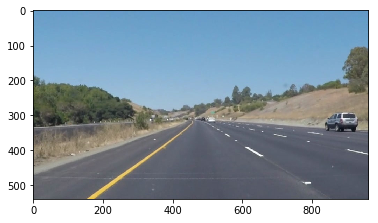

In [4]:
import os
img_list = os.listdir("test_images/")
print(img_list)
for image_name in img_list:
    print(image_name)
plt.imshow(mpimg.imread('test_images/solidYellowCurve.jpg'))


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']
solidYellowCurve.jpg
solidYellowLeft.jpg
solidYellowCurve2.jpg
solidWhiteRight.jpg
whiteCarLaneSwitch.jpg
solidWhiteCurve.jpg


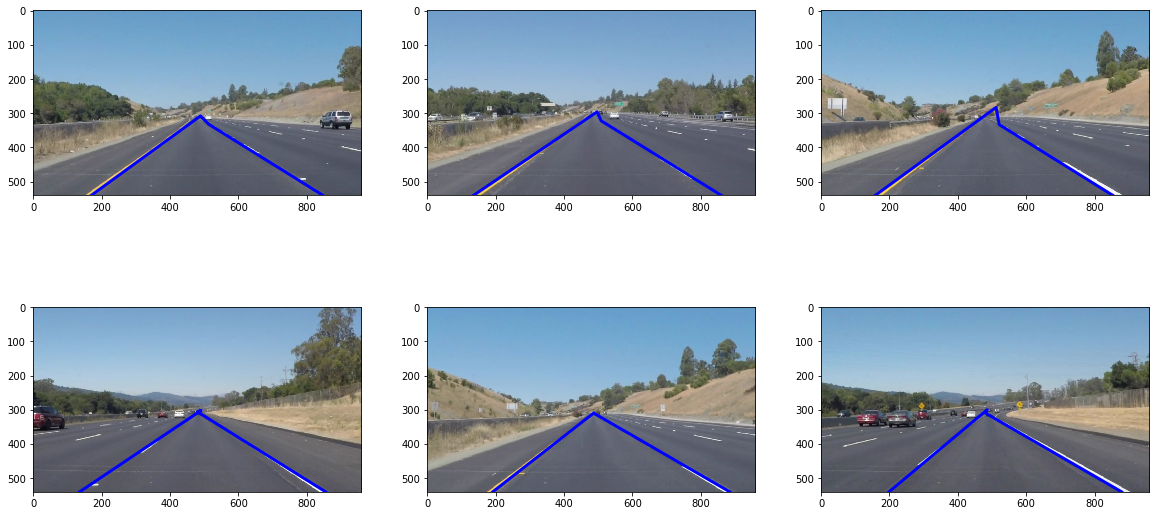

In [5]:
def my_Pipeline(image):
    #print(len(os.listdir("test_images/")))
    #len_img_fold = len(os.listdir("test_images/"))
    #print(str(img_list[2]))

    #image = mpimg.imread('test_images/', str(img_list[1]))
    #plt.imshow(image)
    # then save them to the test_images_output directory.

    # creating the gray scale image from original image
    gray_img = grayscale(image)
    plt.imshow(gray_img)
    #getting the size (row and column) of gray scale image
    gi_row = gray_img.shape[0]
    gi_col = gray_img.shape[1]
    
    #defining the kernel size, it must be odd, starting with 5 or more, because gradient for whole image
    kernel_size = 5
    #Guassian blur for gray scale image based on kernel size
    gb_gray = gaussian_blur(gray_img, kernel_size)   
    #defining the threshold for canny edge detection
    ce_lower_thresh = 120 #120
    ce_higher_thresh = 220 #220
    can_edge = canny(gb_gray, ce_lower_thresh, ce_higher_thresh)
 
    mask = np.zeros_like(can_edge)   
    ignore_mask_color = 255

    #defining the borders for creating and adding the mask
    top_line_y = gi_row * 0.5
    bottom_line_y = gi_row
    
    mask_left_bottom_x = gi_col * 0.15
    mask_left_bottom_y = bottom_line_y
    mask_left_up_x = gi_col * 0.5
    mask_left_up_y = top_line_y
    
    mask_right_bottom_x = gi_col * 0.9
    mask_right_bottom_y = bottom_line_y
    mask_right_up_x = gi_col * 0.7
    mask_right_up_y = top_line_y
    vertices = np.array([[(mask_left_bottom_x, mask_left_bottom_y), (mask_left_up_x, mask_left_up_y), 
                        (mask_right_up_x, mask_right_up_y), (mask_right_bottom_x, mask_right_bottom_y)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(can_edge, mask)
    masked_region = region_of_interest(can_edge, vertices)
      
    #defining the Hough transformation, starting with small values
    rho = 1
    theta =  2*np.pi/180
    thresh_votes = 20#30
    line_len_min = 130
    line_gap_max = 120
    lines = hough_lines(masked_region, rho, theta, thresh_votes, line_len_min, line_gap_max)

    #line_image = np.copy(image)*0 # creating a blank to draw lines on
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    #color_edges = np.dstack((can_edge, can_edge, can_edge))
    
    #alpha = 0.8
    #betha = 1
    #gamma = 0
    #lines_edges = weighted_img(image, line_image, alpha, betha, gamma)
    return lines


def post_process_lines (image, lines):
    #print('there are ', len(lines), ' detected')
    final_lines = []
    max_len_tu = 0
    max_len_td = 0
    idx_line_tu = 0
    idx_line_td = 0
    for line_idx in range(len(lines)):
        len_line = length_of_line(lines[line_idx])
        line_gradient, line_direction = gradient_cal(lines[line_idx])
        #print('line  ', line_idx, ': line length: ', len_line, ', line gradient: ',line_gradient, 'line direction: ', line_direction)
        if line_direction == 'upward':
            if len_line>max_len_tu:
                max_len_tu = len_line
                idx_line_tu = line_idx
                final_lines = [lines[0], idx_line_tu]
                for x1,y1,x2,y2 in lines[idx_line_tu]:
                    x_sl = x1
                    x_el = x2
                    y_sl = y1
                    y_el = y2
                x_extended_up, y_extended_up = extend_line(image.shape[0], lines[idx_line_tu], line_gradient, line_direction='upward')

                x_sl = round(x_extended_up)
                y_sl = round(y_extended_up)
        elif line_direction == 'downward':
            if len_line>max_len_td:
                max_len_td = len_line
                idx_line_td = line_idx
                final_lines = [lines[0], idx_line_td]
                for x1,y1,x2,y2 in lines[idx_line_td]:
                    x_sr = x1
                    x_er = x2
                    y_sr = y1
                    y_er = y2
                x_extended_down, y_extended_down = extend_line(image.shape[0], lines[idx_line_td], line_gradient, line_direction='downward')
                x_er = round(x_extended_down)
                y_er = round(y_extended_down)
                               

    #print('selected left line is the line: ', idx_line_tu, ' with length: ', max_len_tu, '(', x_sl, ',', y_sl,')', ' ,(', x_el, ',', y_el, ')')
    #print('selected right line is the line: ', idx_line_td, ' with length: ', max_len_td,  '(', x_sr, ',', y_sr,')', ' ,(', x_er, ',', y_er, ')')
    #----x_intersect, y_intersect = intersection_lines(lines[0], lines[1])
    #print('x_intersect: ', x_intersect, ', y_intersect: ', y_intersect)
    final_lines[0] = [x_sl, x_el, x_sr, x_er]
    final_lines[1] = [y_sl, y_el, y_sr, y_er]
    #cv2.line(line_image,(int(x_sl),int(x_el)),(int(x_sr),int(x_er)),(255,0,0),10)
    #cv2.line(line_image,(int(y_sl),int(y_el)),(int(y_sr),int(y_er)),(255,0,0),10)
    line_image = np.copy(image)*0 
    cv2.line(line_image,(int(x_sl),int(y_sl)),(int(x_el),int(y_el)),(255,0,0),10)
    cv2.line(line_image,(int(x_sr),int(y_sr)),(int(x_er),int(y_er)),(255,0,0),10)
    alpha = 0.8
    betha = 1
    gamma = 0
    final_lines_edges = weighted_img(image, line_image, alpha, betha, gamma)
    
    return (final_lines, final_lines_edges)

f, ((axim1, axim2, axim3), (axim4, axim5, axim6)) = plt.subplots(2,3, figsize=(20,10))
axim = [axim1, axim2, axim3, axim4, axim5, axim6]
print(img_list)
img_idx = 0
for image_name in img_list:
    print(image_name)
    image_comp_name= 'test_images/'+image_name

    
    image = mpimg.imread(image_comp_name)
    
    lines =my_Pipeline(image)
    final_lines, final_lines_edges = post_process_lines(image, lines)
    plt.imshow(final_lines)
    axim[img_idx].imshow(image)
    axim[img_idx].plot(final_lines[0], final_lines[1], 'b-', lw=3)
    axim[img_idx].set_title = image_comp_name
    img_idx +=1
    

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def img_process(image):
    lines = my_Pipeline(image)
    final_lines, final_lines_edges = post_process_lines(image, lines)
    return final_lines_edges

Let's try the one with the solid white lane on the right first ...

t:   1%|▏         | 3/221 [00:00<00:08, 25.99it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 4.92 s, sys: 576 ms, total: 5.49 s
Wall time: 16.9 s


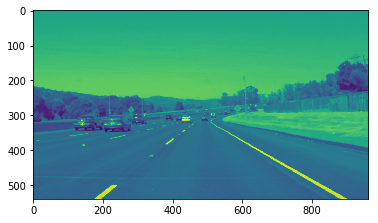

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(img_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!




                                                       



                                                    
                                                                 






                                                                    







                                        




                                                 

                                                              





                                              


t:  19%|█▉        | 131/681 [1:46:25<00:29, 18.47it/s, now=None]



t:   1%|          | 5/681 [1:51:07<250:23:06, 1333.41s/it, now=None]






t:   1%|          | 5/681 [1:53:03<254:44:28, 1356.61s/it, now=None][A







t:  74%|███████▍  | 507/681 [1:36:31<00:07, 22.52it/s, now=None]




t:  81%|████████  | 178/221 [1:44:48<00:02, 19.18it/s, now=None]

t:   1%|          | 5/681 [1:48:54<245:24:10, 1306.88s/it, now=None]





t:  74%|███████▍  | 507/681 [1:42:22<00:05, 34.07it/s, now=None]


                           

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4












t:   1%|          | 4/681 [00:00<00:19, 35.63it/s, now=None]








t:   1%|          | 8/681 [00:00<00:19, 35.13it/s, now=None]








t:   2%|▏         | 11/681 [00:00<00:20, 32.18it/s, now=None]








t:   2%|▏         | 15/681 [00:00<00:19, 33.41it/s, now=None]








t:   3%|▎         | 19/681 [00:00<00:19, 33.82it/s, now=None]








t:   3%|▎         | 22/681 [00:00<00:20, 32.43it/s, now=None]








t:   4%|▍         | 26/681 [00:00<00:19, 32.78it/s, now=None]








t:   4%|▍         | 30/681 [00:00<00:19, 33.27it/s, now=None]








t:   5%|▌         | 35/681 [00:01<00:17, 36.28it/s, now=None]








t:   6%|▌         | 39/681 [00:01<00:17, 36.55it/s, now=None]








t:   6%|▋         | 43/681 [00:01<00:17, 37.48it/s, now=None]








t:   7%|▋         | 47/681 [00:01<00:17, 36.36it/s, now=None]








t:   7%|▋         | 51/681 [00:01<00:22, 27.73it/s, now=None]








t:   8%|▊         | 55/681 [00:01<00:23, 27.00it/s, now=None]








t:   9%|▊    

t:  76%|███████▌  | 517/681 [00:20<00:07, 23.01it/s, now=None]








t:  76%|███████▋  | 520/681 [00:20<00:06, 23.59it/s, now=None]








t:  77%|███████▋  | 523/681 [00:20<00:06, 24.20it/s, now=None]








t:  77%|███████▋  | 526/681 [00:20<00:06, 24.53it/s, now=None]








t:  78%|███████▊  | 529/681 [00:20<00:06, 23.55it/s, now=None]








t:  78%|███████▊  | 532/681 [00:21<00:06, 23.74it/s, now=None]








t:  79%|███████▊  | 535/681 [00:21<00:06, 23.73it/s, now=None]








t:  79%|███████▉  | 538/681 [00:21<00:05, 24.18it/s, now=None]








t:  79%|███████▉  | 541/681 [00:21<00:05, 24.78it/s, now=None]








t:  80%|███████▉  | 544/681 [00:21<00:05, 24.79it/s, now=None]








t:  80%|████████  | 547/681 [00:21<00:05, 24.55it/s, now=None]








t:  81%|████████  | 550/681 [00:21<00:05, 24.40it/s, now=None]








t:  81%|████████  | 553/681 [00:21<00:05, 23.63it/s, now=None]








t:  82%|████████▏ | 556/681 [00:22<00:05, 24.24it/s, now=None]








t:  82

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 14.9 s, sys: 1.65 s, total: 16.5 s
Wall time: 28.9 s


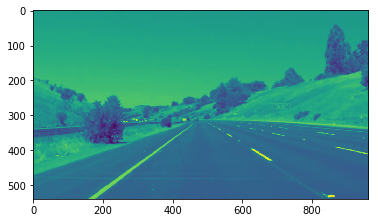

In [776]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(img_process)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [777]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!




                                                       



                                                    
                                                                 






                                                                    







                                        




                                                 

                                                              





                                              


t:  19%|█▉        | 131/681 [1:48:28<00:29, 18.47it/s, now=None]



t:   1%|          | 5/681 [1:53:10<255:00:10, 1358.00s/it, now=None]






t:   1%|          | 5/681 [1:55:05<259:21:31, 1381.20s/it, now=None][A







t:  74%|███████▍  | 507/681 [1:38:34<00:07, 22.52it/s, now=None]




t:  81%|████████  | 178/221 [1:46:51<00:02, 19.18it/s, now=None]

t:   1%|          | 5/681 [1:50:57<250:01:22, 1331.48s/it, now=None]





t:  74%|███████▍  | 507/681 [1:44:25<00:05, 34.07it/s, now=None]


                           

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4












t:   1%|          | 3/251 [00:00<00:10, 24.55it/s, now=None]








t:   2%|▏         | 5/251 [00:00<00:11, 22.33it/s, now=None]








t:   3%|▎         | 7/251 [00:00<00:12, 20.32it/s, now=None]








t:   4%|▎         | 9/251 [00:00<00:12, 20.06it/s, now=None]








t:   5%|▍         | 12/251 [00:00<00:10, 21.98it/s, now=None]








t:   6%|▌         | 15/251 [00:00<00:10, 23.21it/s, now=None]








t:   7%|▋         | 18/251 [00:00<00:09, 23.99it/s, now=None]








t:   8%|▊         | 21/251 [00:00<00:09, 24.43it/s, now=None]








t:  10%|▉         | 25/251 [00:01<00:09, 24.18it/s, now=None]








t:  11%|█         | 28/251 [00:01<00:11, 18.76it/s, now=None]








t:  12%|█▏        | 31/251 [00:01<00:15, 14.19it/s, now=None]








t:  13%|█▎        | 33/251 [00:01<00:17, 12.40it/s, now=None]








t:  14%|█▍        | 35/251 [00:02<00:18, 11.97it/s, now=None]








t:  15%|█▍        | 37/251 [00:02<00:17, 11.90it/s, now=None]








t:  16%|█▌     

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 9.37 s, sys: 1.4 s, total: 10.8 s
Wall time: 21.9 s


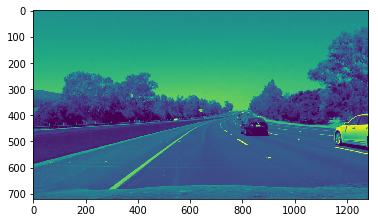

In [778]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(img_process)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [779]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))